# **Dependancies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


# **Loading Data**

In [ ]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)


# Hiển thị 10 dòng đầu tiên
data.head(10)


,Date,priceUSD,size,sentbyaddress,transactions,mining_profitability,sentinusd,transactionfees,median_transaction_fee,confirmationtime,marketcap,transactionvalue,mediantransactionvalue,tweets,google_trends,fee_to_reward,activeaddresses,top100cap
0,2014/04/09,447.110,243742.0,122401,64992,38.678,239212041.0,0.1390,0.0447,8.944,5587996110,4115.0,100.420,8193,11.193,0.502,179274,19.211
1,2014/04/10,407.703,254334.0,124298,67872,31.917,310367120.0,0.0864,0.0408,9.290,5020359905,4876.0,120.946,15039,13.854,0.371,182996,19.166
2,2014/04/11,403.328,223656.0,117926,65563,36.814,292756343.0,0.0858,0.0403,8.521,5068919648,4819.0,108.481,14907,12.997,0.330,169622,19.141
3,2014/04/12,425.310,169964.0,87828,47579,34.498,157264741.0,0.0811,0.0425,8.944,5329088351,3574.0,84.408,7582,9.229,0.226,132283,19.145
4,2014/04/13,415.876,162260.0,94828,50981,34.141,154756367.0,0.0840,0.0416,7.701,5150414718,3332.0,69.681,10674,10.385,0.221,172708,19.131
5,2014/04/14,445.898,216048.0,127969,70026,37.973,253143718.0,0.0977,0.0446,7.461,5628122040,3990.0,115.249,13266,10.754,0.318,183291,19.146
6,2014/04/15,487.666,241539.0,123107,72627,38.650,293892234.0,0.1110,0.0488,7.912,6170470953,4479.0,123.089,14835,11.053,0.362,199054,19.124
7,2014/04/16,517.354,270984.0,114312,68435,40.201,389249585.0,0.1080,0.0517,9.057,6496569317,6046.0,129.799,15790,12.189,0.359,185075,19.146
8,2014/04/17,505.461,223631.0,102596,65021,40.706,385378002.0,0.1170,0.0505,8.521,6281237538,6384.0,102.416,15215,11.471,0.355,157751,19.092
9,2014/04/18,485.296,205478.0,100633,56836,35.818,360602878.0,0.1040,0.0485,9.000,5972292967,6461.0,107.713,14028,9.946,0.304,149452,19.054


# **Model Architecture + Training**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


# Define DiffusionProcess class
class DiffusionProcess:
    def __init__(self, beta_start=0.0, beta_end=1.0, diff_steps=1000, device='cpu'):
        self.T = diff_steps
        self.beta = torch.linspace(beta_start, beta_end, diff_steps, device=device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)


    def q_sample(self, x0, t):
        if isinstance(t, int):
            t = torch.full((x0.shape[0],), t, dtype=torch.long, device=x0.device)
        alpha_bar_t = self.alpha_bar[t].view(-1, *([1] * (x0.dim() - 1)))
        noise = torch.randn_like(x0)
        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise
        return xt

# Define DiffusionVAE class
class DiffusionVAE(nn.Module):
    def __init__(self, feature_dim, latent_dim=16):
        super(DiffusionVAE, self).__init__()
        hidden_dim = 64
        enc_input_dim = feature_dim + 2
        self.encoder = nn.Sequential(
            nn.Linear(enc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        dec_input_dim = latent_dim + feature_dim + 1
        self.decoder = nn.Sequential(
            nn.Linear(dec_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, features, x_t, t):
        inputs = torch.cat([features, t, x_t], dim=1)
        h = self.encoder(inputs)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        dec_inputs = torch.cat([z, features, t], dim=1)
        output = self.decoder(dec_inputs)
        return output, mu, logvar

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create save directory
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/Training_Model_Diffusion-VAE_V28'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_diffusion_vae.pt')

# --- Bước 1: Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test ---
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

n = len(df)
n_train = int(n * 0.8)
n_val = int(n * 0.1)
n_test = n - n_train - n_val

train_df = df.iloc[:n_train].reset_index(drop=True)
val_df = df.iloc[n_train:n_train+n_val].reset_index(drop=True)
test_df = df.iloc[n_train+n_val:].reset_index(drop=True)

numeric_cols = ['priceUSD', 'size', 'sentbyaddress', 'transactions',
                'mining_profitability', 'sentinusd', 'transactionfees',
                'median_transaction_fee', 'confirmationtime',
                'marketcap', 'transactionvalue', 'mediantransactionvalue',
                'tweets', 'google_trends', 'fee_to_reward',
                'activeaddresses', 'top100cap']
feature_cols = [col for col in numeric_cols if col != 'priceUSD']
target_col = 'priceUSD'

# Chuẩn hóa dữ liệu trên tập train, áp dụng cho val và test
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_X = scaler_X.fit_transform(train_df[feature_cols].values)
train_y = scaler_y.fit_transform(train_df[[target_col]].values)
val_X = scaler_X.transform(val_df[feature_cols].values)
val_y = scaler_y.transform(val_df[[target_col]].values)
test_X = scaler_X.transform(test_df[feature_cols].values)
test_y = scaler_y.transform(test_df[[target_col]].values)

# Tensor và DataLoader
def create_loader(X, y, batch_size=32, shuffle=False):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

batch_size = 32
train_loader = create_loader(train_X, train_y, batch_size, shuffle=True)
val_loader = create_loader(val_X, val_y, batch_size)
test_loader = create_loader(test_X, test_y, batch_size)

# Khởi tạo mô hình và diffusion
feature_dim = train_X.shape[1]
latent_dim = 16
model = DiffusionVAE(feature_dim=feature_dim, latent_dim=latent_dim).to(device)
diffusion = DiffusionProcess(beta_start=0.0, beta_end=1.0, diff_steps=1000, device=device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 300
best_val_loss = float('inf')

for epoch in range(1, n_epochs+1):
    model.train()
    train_losses = []
    for features, target in train_loader:
        features = features.to(device)
        target = target.to(device)
        batch_size_cur = features.size(0)
        t = torch.randint(0, diffusion.T, (batch_size_cur,), device=device)
        x_t = diffusion.q_sample(target, t)
        t_norm = (t.float()/diffusion.T).unsqueeze(1).to(device)

        optimizer.zero_grad()
        output, mu, logvar = model(features, x_t, t_norm)
        recon_loss = criterion(output, target)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss_epoch = np.mean(train_losses)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for features, target in val_loader:
            features = features.to(device)
            target = target.to(device)
            batch_size_cur = features.size(0)
            t = torch.randint(0, diffusion.T, (batch_size_cur,), device=device)
            x_t = diffusion.q_sample(target, t)
            t_norm = (t.float()/diffusion.T).unsqueeze(1).to(device)

            output, mu, logvar = model(features, x_t, t_norm)
            recon_loss = criterion(output, target)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            val_losses.append(loss.item())
    val_loss_epoch = np.mean(val_losses)

    # Test loss (để theo dõi, không dùng để save model)
    test_losses = []
    with torch.no_grad():
        for features, target in test_loader:
            features = features.to(device)
            target = target.to(device)
            batch_size_cur = features.size(0)
            t = torch.randint(0, diffusion.T, (batch_size_cur,), device=device)
            x_t = diffusion.q_sample(target, t)
            t_norm = (t.float()/diffusion.T).unsqueeze(1).to(device)

            output, mu, logvar = model(features, x_t, t_norm)
            recon_loss = criterion(output, target)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            test_losses.append(loss.item())
    test_loss_epoch = np.mean(test_losses)

    print(f"Epoch {epoch}: Train Loss={train_loss_epoch}, Val Loss={val_loss_epoch}, Test Loss={test_loss_epoch}")

    # Lưu mô hình tốt nhất dựa trên val loss
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), save_path)

# Load mô hình tốt nhất
model.load_state_dict(torch.load(save_path))
model.eval()

# Hàm dự đoán với diffusion ngược cho bất kỳ loader nào
# Chỉ lấy preds trong hàm
def predict_with_diffusion(loader):
    preds = []
    with torch.no_grad():
        for features, target in loader:
            features = features.to(device)
            target = target.to(device)
            x = diffusion.q_sample(target, diffusion.T-1)
            for t_step in range(diffusion.T-1, 0, -1):
                t_tensor = torch.full((features.size(0), 1), t_step, device=device, dtype=torch.long)
                t_norm = t_tensor.float() / diffusion.T
                pred_x0, _, _ = model(features, x, t_norm)
                if t_step > 1:
                    alpha_bar_prev = diffusion.alpha_bar[t_step-1]
                    noise = torch.randn_like(x)
                    x = torch.sqrt(alpha_bar_prev) * pred_x0 + torch.sqrt(1 - alpha_bar_prev) * noise
            preds.extend(pred_x0.cpu().numpy().flatten().tolist())
    preds = np.array(preds).reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds).flatten()
    return preds

# Lấy actuals từ dữ liệu gốc (đã chuẩn hóa) rồi scale ngược lại
train_actuals = scaler_y.inverse_transform(train_y).flatten()
val_actuals = scaler_y.inverse_transform(val_y).flatten()
test_actuals = scaler_y.inverse_transform(test_y).flatten()

train_preds = predict_with_diffusion(train_loader)
val_preds = predict_with_diffusion(val_loader)
test_preds = predict_with_diffusion(test_loader)


# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

# Hàm in chỉ số
def print_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {dataset_name} Metrics ---")
    print(f"MAE: {mae:.6f}")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAPE: {mape:.6f} %")
    print(f"R^2: {r2:.6f}\n")

#print_metrics(train_actuals, train_preds, "Train")
print_metrics(val_actuals, val_preds, "Validation")
print_metrics(test_actuals, test_preds, "Test")


Epoch 1: Train Loss=0.015557366647408344, Val Loss=0.190351053327322, Test Loss=0.04292460223659873
Epoch 2: Train Loss=0.006645851171924733, Val Loss=0.07112594246864319, Test Loss=0.02496265680529177
Epoch 3: Train Loss=0.003673704998800531, Val Loss=0.04541691755875945, Test Loss=0.05222697490826249
Epoch 4: Train Loss=0.0021386523418186697, Val Loss=0.05846005538478494, Test Loss=0.07260781300719828
Epoch 5: Train Loss=0.0014977636987168808, Val Loss=0.06086407583206892, Test Loss=0.07612025161506608
Epoch 6: Train Loss=0.0014929575387213844, Val Loss=0.06204291167668998, Test Loss=0.07797308614244684
Epoch 7: Train Loss=0.0011084524121542927, Val Loss=0.054693662794306874, Test Loss=0.06692067793337628
Epoch 8: Train Loss=0.0009479928317887243, Val Loss=0.05677984501235187, Test Loss=0.06775998375960626
Epoch 9: Train Loss=0.0008813619315333199, Val Loss=0.041321645863354205, Test Loss=0.04792077156016603
Epoch 10: Train Loss=0.0007759043975966052, Val Loss=0.04994650306180119, Te

In [ ]:
# Tạo DataFrame lưu kết quả Actual - Predicted cho tập test
results = pd.DataFrame({
    'Actual': test_actuals,
    'Predicted': test_preds
})
print(results.head(10))
# Lưu kết quả ra file csv
results_path = os.path.join(save_dir, 'result_predictions_DVAE_model.csv')
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

    Actual     Predicted
0  43854.0  44005.398735
1  43922.0  44200.732868
2  44331.0  44815.650236
3  43185.0  43629.827476
4  42333.0  42794.296934
5  42336.0  42238.517291
6  42232.0  42532.244238
7  43867.0  43993.326879
8  43998.0  44471.257420
9  42666.0  42868.793940
Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/Training_Model_Diffusion-VAE_V28/result_predictions_DVAE_model.csv


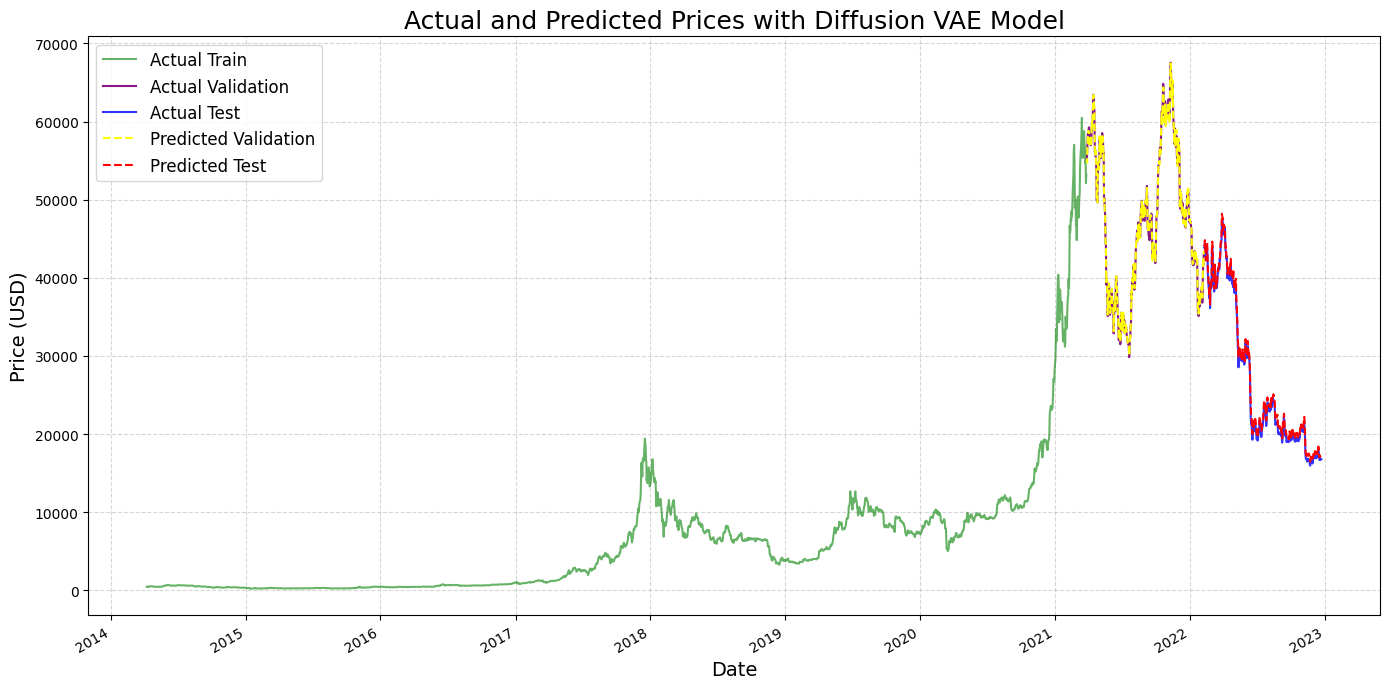

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# data với cột 'Date'
train_dates = pd.to_datetime(data['Date'].iloc[:len(train_preds)])
val_dates = pd.to_datetime(data['Date'].iloc[len(train_preds):len(train_preds)+len(val_preds)])
test_dates = pd.to_datetime(data['Date'].iloc[len(train_preds)+len(val_preds):len(train_preds)+len(val_preds)+len(test_preds)])

plt.figure(figsize=(14, 7))

# Actual Train
plt.plot(train_dates, train_actuals.flatten(), label='Actual Train', color='green', alpha=0.6)

# Actual Validation
plt.plot(val_dates, val_actuals.flatten(), label='Actual Validation', color='purple', alpha=0.9)

# Actual Test
plt.plot(test_dates, test_actuals.flatten(), label='Actual Test', color='blue', alpha=0.8)

# Predicted Train
#plt.plot(train_dates, train_preds.flatten(), label='Predicted Train', linestyle='--', color='lime')

# Predicted Validation
plt.plot(val_dates, val_preds.flatten(), label='Predicted Validation', linestyle='--', color='yellow')

# Predicted Test
plt.plot(test_dates, test_preds.flatten(), label='Predicted Test', linestyle='--', color='red')

# Định dạng trục x (theo năm)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Actual and Predicted Prices with Diffusion VAE Model', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


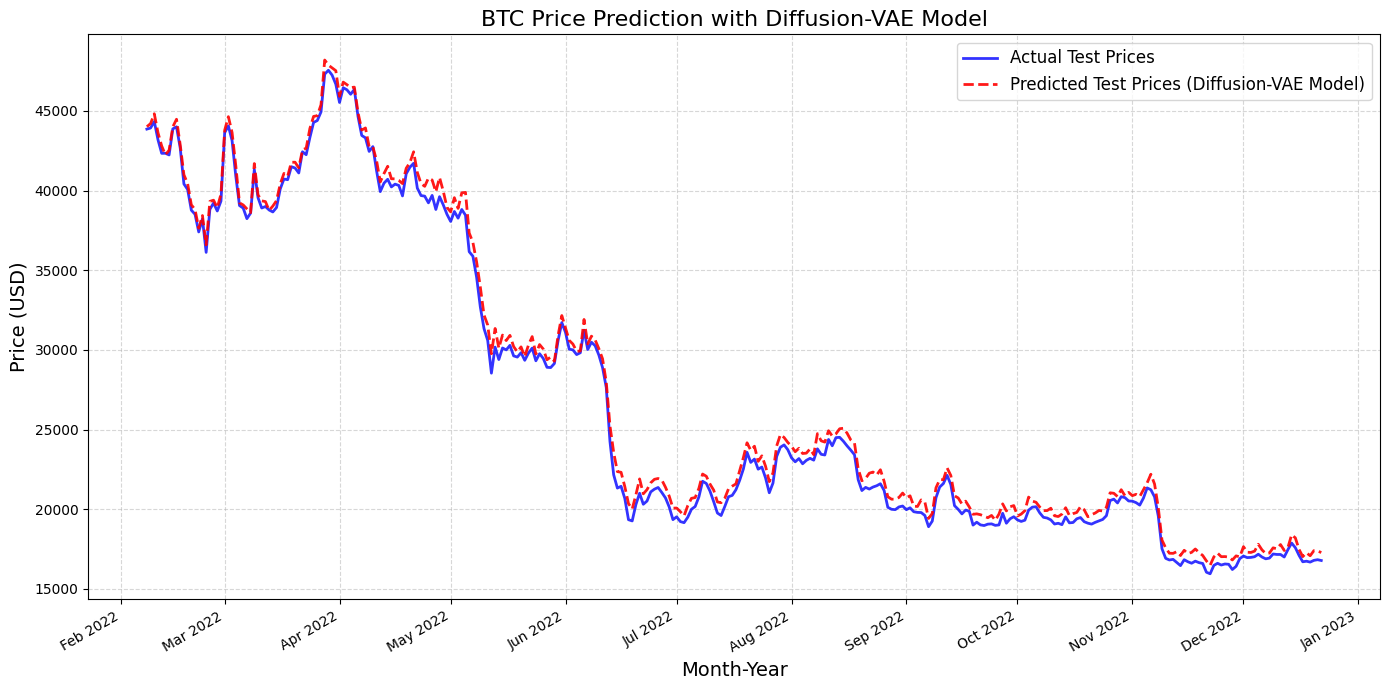

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

#'data' có cột 'Date'
data['Date'] = pd.to_datetime(data['Date'])

# Chỉ số tách 10% test
split_index = int(len(data) * 0.9)

# Lấy dates tập test (phần cuối 10%)
dates_test = data['Date'].iloc[split_index:].reset_index(drop=True)

# Lấy actual và predicted test từ diffusion model (đã scale ngược)
y_test_vals = test_actuals  # actuals
pred_test_vals = test_preds # predicted

# Cắt cho khớp chiều dài với dates_test nếu cần
min_len = min(len(dates_test), len(y_test_vals), len(pred_test_vals))
dates_test = dates_test.iloc[:min_len]
y_test_vals = y_test_vals[:min_len]
pred_test_vals = pred_test_vals[:min_len]

plt.figure(figsize=(14, 7))

# Vẽ giá thực tế tập test
plt.plot(dates_test, y_test_vals,
         label='Actual Test Prices', color='blue', linewidth=2, alpha=0.8)

# Vẽ giá dự đoán tập test từ mô hình D-VAE
plt.plot(dates_test, pred_test_vals,
         label='Predicted Test Prices (Diffusion-VAE Model)',
         color='red', linestyle='--', linewidth=2, alpha=0.9)

# Định dạng trục x hiển thị tháng-năm, cách 1 tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

# Tiêu đề, nhãn trục, chú thích
plt.title('BTC Price Prediction with Diffusion-VAE Model', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)

# Lưới, căn chỉnh bố cục
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()
